<a href="https://colab.research.google.com/github/miguelzttn/portfolio_ml/blob/main/cachorro_vs_gato_cnn_vgg16_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# É um cachorro  ou um gato? Transfer learning em um modelo de redes neurais convolucionais com imagens do google

Em quase todas as linguagens de programação, o primeiro comando que se testa é uma equivalência do `console.log('hello world')`.

Talvez, para as redes neurais, o equivalente desta iniciação sejam os exercícios de separar cachorros de gatos.


In [ ]:

# Misc
import os
import random
import numpy as np
import pandas as pd

# Web scrapping
import requests
import PIL
from bs4 import BeautifulSoup
from io import BytesIO

# Plots
import matplotlib.pyplot as plt

# Keras framework
import keras

from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

from typing import Tuple, List, Dict, Any

random.seed(252)

## Encontrando uma base de dados

Recomenda-se, para treinar um modelo de visão computacional, que se utilize uma base de dados contendo pelo menos duzentos exemplos para cada categoria.


É muito distante da realidade utilizar uma base de dados já tratada, com imagens bem delimitadas e pensadas para a solução do problema. Em casos reais, espera-se que os dados não sejam perfeitos, que possuam séries de inconsistências e não reflitam necessariamente o problema. Por isso é que o tratamento de dados é tão importante para a ciência de dados.


Quando se pensa em buscar imagens, entretanto, certamente o Google Images é a ferramenta mais difundida entre a população em geral.

A ideia, então, é de utilizar esta ferramenta para montar uma base de dados com mais de uma centena de exemplos para cada uma das categorias (cachorro ou gato).

## Web-scrapping com o Google Images

### Implementando funcionalidade

Quando uma consulta é realizada no Google Images, os parâmetros da busca são passados no conteúdo da requisição. O blogpost de Nutan (2023) na plataforma Medium descreve uma extração de web-scrapping considerando a modificação deste URL, então a utilização de ferramenta de leitura de HTML para identificar todos os elementos `<img>` presentes na resposta, sempre validando se eles iniciam com `https:\\` a fim de evitar coletar imagens equivocadas.


Abaixo, um exemplo da extração do primeiro resultado que se obtém no Google Images quando se busca pelo nome do autor.

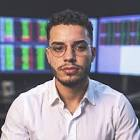

In [ ]:

termo = 'Miguel Zanchettin'

base_url = (
    rf'https://www.google.com/search?q={termo}&'
    'tbm=isch&'
    'rlz=1C1GCEU_pt-BRBR1061BR1061'
    )

resposta = requests.get(base_url)

soup = BeautifulSoup(resposta.text, 'html.parser')

links = [img.get('src')
        for img in soup.find_all('img')
        if img.get('src').startswith('https://')]

# mostra a primeira imagem imagens
bytes = requests.get(links[0]).content
img = PIL.Image.open(BytesIO(bytes))
img


Considerando que serão necessárias a extração de centenas de imagens, pode-se implementar uma função que realiza a extração de todos os resultados de imagens retornadas ao pesquisar um termo no Google Images.

In [ ]:


def pesquisar_no_google_images(termo: str) -> List[str]:

    url = (
        r'https://www.google.com/'
        f'search?q={termo}&tbm=isch'
        '&rlz=1C1GCEU_pt-BRBR1061BR1061'
        )

    resposta = requests.get(url)

    if resposta.status_code >= 400:
        raise ConnectionRefusedError(
            'Conexao recusada!'
            ' Talvez voce tenha excedido'
            ' o limite de extracoes...'
            )

    soup = BeautifulSoup(resposta.text, 'html.parser')

    links = [img.get('src')
            for img in soup.find_all('img')
            if img.get('src').startswith('https://')]

    return links

lista = pesquisar_no_google_images('lirio')
lista[:3]


['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQuKQuEq7Ue92V7snAk7JInvUvmlmtNlpQga67VG4Oql2VQRuaE1bHvM9ws4Bc&s',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTUgp0-VJ-u34puNKjECy3DnndK4M9ySaxbIaD9yLbYTMwDhls565B6GP75abw&s',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSAR-AfAY2Bto3-mkbBDE0d-HPAPjx6vBA81FqEYlIzRWHgiY0WAHY_ZG81nQ&s']

A função acima lida perfeitamente com a extração das imagens. Porém, para identificar uma série de termos, é preferível que se implante uma outra funcionalidade: buscar uma série de rótulos e retornar todas as imagens para cada um.

Idealmente, este retorno obedeceria um formato de dicionário, com o termo pesquisado sendo a chave e os valores como uma lista de todos os links das imagens resultantes.

Como uma função referenciaria outra, abaixo, implementa-se a classe GoogleImages, com as duas funcionalidades mencionadas como métodos.

In [ ]:

class GoogleImages:

    def __init__(self) -> None:
        pass

    def pesquisar(self,
                  pesquisa: str,
                  n_resultados: int = 20) -> List[str]:
        """
            Pesquisa algo e retorna lista com 20 link de imagens
            reultantes.

            n_resultados: Cada pagina contem 20 itens
        """

        if n_resultados <= 0:
            raise ValueError('Precisa ser um numero valido.')

        paginas = (n_resultados // 20) + 1

        resultados = []

        for pagina in range(paginas):

            url = (
                r'https://www.google.com/'
                f'search?q={pesquisa}&tbm=isch'
                '&rlz=1C1GCEU_pt-BRBR1061BR1061'
                f'&dpr={pagina+1}'
                )

            resposta = requests.get(url)

            if resposta.status_code >= 400:
                raise ConnectionRefusedError(
                    'Conexao recusada!'
                    ' Talvez voce tenha excedido'
                    ' o limite de extracoes...'
                    )

            soup = BeautifulSoup(resposta.text, 'html.parser')

            links = [img.get('src')
                    for img in soup.find_all('img')
                    if img.get('src').startswith('https://')]

            for _ in links:
                resultados.append(_)

        return resultados[:n_resultados-1]

    def pesquisar_lista(self,
                        lista: list,
                        n_resultados: int = 20
                        ) -> Dict[str, List[str]]:
        """
            Pesquisa uma lista de imagens e retorna um dicionario
            com a lista links de resultados.
        """

        resultados = {}

        for pesquisa in lista:
            resultados[pesquisa] = self.pesquisar(pesquisa,
                                                  n_resultados)

        return resultados



Testando-a para uma pesquisa em lista e exibindo o primeiro resultado:

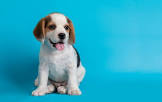

In [ ]:
classes = ['Cachorro', 'Gato']

google = GoogleImages()
lista = google.pesquisar_lista(classes, 10)

# Mostra a primeira imagem
imagem1 = lista[classes[0]][0]
resposta = requests.get(imagem1)
img = PIL.Image.open(BytesIO(resposta.content))
img

### Extraindo a base de dados

Com a classe definida anteriormente, pode-se agora realizar a extração da base de dados.

Para este estudo, serão utilizados duzentas imagens de exemplo para cada classe.


In [ ]:

categorias = ['Cachorro', 'Gato']

google = GoogleImages()
imagens = google.pesquisar_lista(categorias, 200)


O excerto acima realiza a extração do link que se refere as imagens. Porém, o modelo a ser treinado utiliza como entrada matrizes no formato (244, 244, 3).

Para transformar os links nessas matrizes, é necessário, antes, realizar a sua leitura e então o pré-processamento. Quanto à leitura, abaixo é implementada a função `salvar_imagem(url, destino)` que lê uma imagem de um URL e a salva em um diretório de destino. Quanto ao pré processamento, implementa-se a função `ler_imagem(caminho)`, que lê a imagem em um caminho e a processa, retornando uma tupla, contendo a imagem e sua matriz no formato de entrada para o modelo.

In [ ]:

def salvar_imagem(url: str, destino: str) -> None:

    resposta = requests.get(url)
    img = PIL.Image.open(BytesIO(resposta.content))

    rgb_img = img.convert('RGB')
    rgb_img.save(destino)
    return

def processar_imagem(caminho: str) -> Tuple[Any, Any]:

    img = keras.utils.load_img(caminho, target_size=(224, 224))

    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return (img, x)



Considerando a lista de imagens extraida previamente e as funções implementadas, gera-se a base de dados por meio de um processo iterativo que salva, processa e apaga cada imagem da lista, reduzindo ao máximo o consumo de espaço em disco - embora com custo computacional maior por iteração.

O resultado é uma lista de dicionários, com um `x` multidimensional e um `y` unidimensional (rótulo).


In [ ]:
dados = []

for categoria, lista in enumerate(imagens.values()):

    for link in lista:

        salvar_imagem(link, 'tmp.jpg')
        img, x = processar_imagem('tmp.jpg')

        os.remove('tmp.jpg')

        linha = {'x': np.array(x[0]), 'y': categoria}
        dados.append(linha)

print(dados[0])


{'x': array([[[ 106.061,   60.221, -123.68 ],
        [ 106.061,   60.221, -123.68 ],
        [ 106.061,   60.221, -123.68 ],
        ...,
        [ 123.061,   76.221,  -97.68 ],
        [ 123.061,   76.221,  -97.68 ],
        [ 121.061,   76.221,  -97.68 ]],

       [[ 106.061,   60.221, -123.68 ],
        [ 106.061,   60.221, -123.68 ],
        [ 106.061,   60.221, -123.68 ],
        ...,
        [ 123.061,   76.221,  -97.68 ],
        [ 123.061,   76.221,  -97.68 ],
        [ 121.061,   76.221,  -97.68 ]],

       [[ 106.061,   60.221, -123.68 ],
        [ 106.061,   60.221, -123.68 ],
        [ 106.061,   60.221, -123.68 ],
        ...,
        [ 121.061,   76.221,  -97.68 ],
        [ 121.061,   76.221,  -97.68 ],
        [ 121.061,   76.221,  -97.68 ]],

       ...,

       [[  88.061,   40.221, -123.68 ],
        [  88.061,   40.221, -123.68 ],
        [  88.061,   40.221, -123.68 ],
        ...,
        [ 104.061,   57.221, -123.68 ],
        [ 104.061,   57.221, -123.68 ],
   

## Treinando o modelo

Para este estudo, optou-se por utilizar um método baseado em *transfer learning*, isto é, partir de uma rede com pesos já treinados para um objetivo e adaptá-la para um problema em específico.

A rede em questão é a VGG16, segundo o blogpost de Great Learning (2012) no Medium, modelo proposto por Symonian e Zisserman (2014) em um artigo da universidade Cornell. Os resultados deste modelo venceram a competição *2015 ImageNet Large-Scale Visual Recognition Challenge*, a *ICLR 2015*, uma competição de modelos heurísticos capazes de identificar, com a maior precisão, todas as classes de imagens presentes em um banco de dados chamado *ImageNet*, da universidade de Princenton.

### Importando o modelo

Este modelo está disponível no framework Keras. Abaixo, demonstra-se sua importação. Cabe destaque ao peso deste modelo: são mais de 553MB.

In [ ]:

vgg = keras.applications.VGG16(
    weights='imagenet',
    include_top=True
    )

vgg.summary()


553467096/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

### Adequando a rede para o problema

O código abaixo realiza a remoção da última camada do modelo (predictions) e adiciona, em seu lugar, uma nova camada densa, com um neurônio para cada categoria de interesse (cachorro ou gato), utilizando a função de ativação *softmax*.

In [ ]:
camada_entrada = vgg.input

nova_camada = Dense(len(categorias), activation='softmax')

camada_saida = nova_camada(vgg.layers[-2].output)

modelo = Model(camada_entrada, camada_saida)


A compilação do modelo considerando estas definições exigiria, para treinamento, um custo computacional gigantesco, uma vez que este seria realizado para todas as camadas da rede por conta do *backpropagation*.

Como os recursos computacionais são limitados - a GPU do Google Colab -, será treinada apenas a última camada do modelo. Isto é o mesmo que assumir que todas as outra camadas já têm noção suficiente de elementos que compoem as categorias desejadas, por exemplo, já é capaz de separar um animal de um veículo.


In [ ]:

for camada in modelo.layers:

    camada.trainable = False

    if camada in modelo.layers[:-1]:
        camada.trainable = True


Agora, pode-se compilar o modelo.

Para isto, utilizar-se-á a função de entropia cruzada binária (binary cross entropy), uma vez que se deseja obter uma classificação de apenas duas classes (cachorro ou gato).

Em função da baixa quantidade de dimensões, será utilizado o gradiente descendente do otimizador ADAM do Keras.

Por fim, como não há prejuízo em falsos positivos, a acurárcia é a métrica utilizada.

In [ ]:

modelo.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

modelo.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Segregando dados em treino, validação e testes

A biblioteca scikit-learn tem uma excelente função para segregação de bases. Porém, para este estudo, optou-se por implementar uma função simplificada para fins de aprendizado.

Destaca-se nesta implementação, o uso da função `keras.utils.to_categorical`, que transforma uma matriz de classes em uma série de matrizes binárias, com um elemento para cada categoria. Também, a transformação de cada matriz individual em uma matriz do Numpy, que é computacionalmente superior.

In [ ]:

def ttv_split(dados,
              pc_treino: float,
              pc_validacao: float,
              pc_teste: float):

    random.shuffle(dados)

    split1 = int(pc_treino * len(dados))
    split2 = int((pc_treino + pc_validacao) * len(dados))

    treino = dados[:split1]
    validacao = dados[split1:split2]
    teste = dados[split2:]

    x_treino = np.array([_['x'] for _ in treino])
    y_treino = np.array([_['y'] for _ in treino])
    y_treino = keras.utils.to_categorical(y_treino)

    x_validacao = np.array([_['x'] for _ in validacao])
    y_validacao = np.array([_['y'] for _ in validacao])
    y_validacao = keras.utils.to_categorical(y_validacao)

    x_teste = np.array([_['x'] for _ in teste])
    y_teste = np.array([_['y'] for _ in teste])
    y_teste = keras.utils.to_categorical(y_teste)

    return \
        x_treino, y_treino, \
        x_validacao, y_validacao, \
        x_teste, y_teste



Por fim, utiliza a função implementada para segregar a base de dados.

Para este estudo, a base é dividida em 70% dos elementos para treino, 15% para validação e 15% para testes.

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = ttv_split(dados,
                                                           0.70,
                                                           0.15,
                                                           0.15)

print(y_test[:10])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


### Executando o treinamento

Considerando as premissas definidas, executa o treinamento do modelo com os dados segregados, em batches de 128 observações para 30 épocas.

In [ ]:

# treina o modelo
resultados = modelo.fit(
    x_train, y_train,
    batch_size=128,
    epochs=30,
    validation_data=(x_val, y_val)
    )



Epoch 1/30
3/3 [==============================] - 101s 14s/step - loss: 25.9894 - accuracy: 0.4101 - val_loss: 8.4917 - val_accuracy: 0.5667
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 7.0386 - accuracy: 0.4784 - val_loss: 1.2563 - val_accuracy: 0.5667
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 3.4708 - accuracy: 0.4281 - val_loss: 0.8731 - val_accuracy: 0.5667
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 1.4811 - accuracy: 0.4712 - val_loss: 0.8081 - val_accuracy: 0.5167
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 0.8346 - accuracy: 0.5576 - val_loss: 1.8882 - val_accuracy: 0.4333
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 1.1443 - accuracy: 0.5647 - val_loss: 0.5698 - val_accuracy: 0.7500
Epoch 7/30
3/3 [==============================] - 4s 1s/step - loss: 0.6295 - accuracy: 0.7050 - val_loss: 0.7845 - val_accuracy: 0.6000
Epoch 8/30
3/3 [=====================

## Resultados

A acurácia top-1 encontrada pelo modelo, considerando os dados utilizados, foi de 91,37% nos testes, com 88,33% em testes.

A fim de melhor compreender a evolução das métricas durante o treinamento, plotam-se os gráficos de perda de validação e a acurácia do modelo

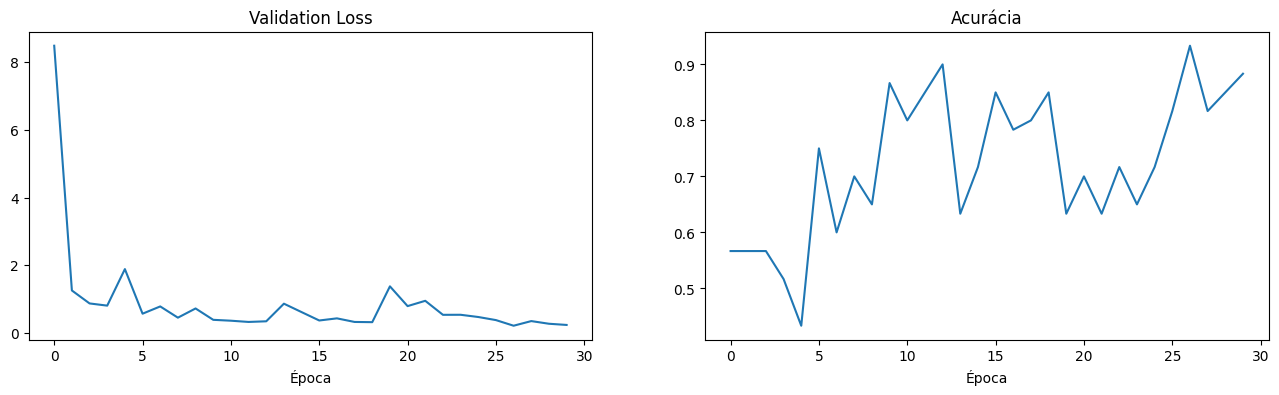

In [ ]:

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1.plot(resultados.history['val_loss'])
ax1.set_title('Validation Loss')
ax1.set_xlabel('Época')

ax2 = fig.add_subplot(122)
ax2.plot(resultados.history['val_accuracy'])
ax2.set_title('Acurácia')
ax2.set_xlabel('Época')

plt.show()




Como a visualização da acurárica indica uma estabilização superior do modelo, pode-se interpretar que o treinamento tornou-se suficiente para o conjunto de dados. A perda de validação tendendo a zero também é um importante indicador deste mesmo sentido.

## Demonstração

A fim de realizar uma demonstração das capacidades do modelo treinado, são buscadas duas imagens no Google Images, uma de um cachorro Yorkshire Mini e outra de um gato Persa.

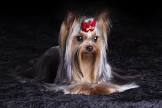

In [ ]:

doguinho = google.pesquisar('Cachorro Yorkshire Mini')[0]

resposta = requests.get(doguinho)
img = PIL.Image.open(BytesIO(resposta.content))
img


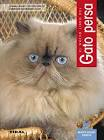

In [ ]:

gatinho = google.pesquisar('Gato Persa')[1]

resposta = requests.get(gatinho)
img = PIL.Image.open(BytesIO(resposta.content))
img


Abaixo, as predições realizadas para o modelo para cada uma das imagens.

In [ ]:

def predizer(caminho: str) -> dict:

    salvar_imagem(caminho, 'tmp.jpg')
    img, x = processar_imagem('tmp.jpg')
    os.remove('tmp.jpg')

    predicao = modelo.predict([x])

    probabilidades = {}
    for _, __ in enumerate(categorias):
        probabilidades[__] = predicao[0][_]

    return probabilidades

print(f'Doguinho: {predizer(doguinho)}')
print(f'Gatinho: {predizer(gatinho)}')

1/1 [==============================] - 0s 33ms/step
Doguinho: {'Cachorro': 0.9517225, 'Gato': 0.048277464}
1/1 [==============================] - 0s 26ms/step
Gatinho: {'Cachorro': 0.07734033, 'Gato': 0.9226597}


## Considerações finais

A elaboração deste projeto é um passo inicial para a compreensão do autor de modelos de redes neurais: embora a implementação de um método como transfer learning não seja o mais complexo, é um importante avanço, pois exige a compreensão do funcionamento da rede, bem como sua implementação em um problema real. Esta última sendo a parte mais relevante no aspecto profissional.

Contudo, ainda há limitações no modelo, uma vez que sua capacidade de generalização não se demonstrou tão eficaz em testes posteriores. Estudos futuros devem ser feitos para implementar melhores métodos e técnicas para gerar uma maior capacidade de inferências corretas.

# Referências

* 2014, Simonyan K. e Zisserman A. [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

* 2019, Kylemath M. [Transfer Learning in python](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb#scrollTo=YpRcsywEYobT)

* 2021, Great Learning [Everything you need to know about VGG16](https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918)

* 2023, Nutan. [How to Scrape Images from Google Search Engines in Python](https://medium.com/@nutanbhogendrasharma/how-to-scrape-images-from-google-search-engines-in-python-d76397812066)



